In [2]:
import pip
! pip install xlrd
! pip install openpyxl
! pip install tensorflow

  Using cached xlrd-2.0.1-py2.py3-none-any.whl (96 kB)
  Using cached openpyxl-3.1.2-py2.py3-none-any.whl (249 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)
  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/e2/7a/c7762c698fb1ac41a7e3afee51dc72aa3ec74ae8d2f57ce19a9cded3a4af/tensorflow-2.14.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached tensorflow-2.14.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Obtaining dependency information for ml-dtypes==0.2.0 from https://files.pythonhosted.org/packages/d1/1d/d5cf76e5e40f69dbd273036e3172ae4a614577cb141673427b80cac948df/ml_dtypes-0.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached ml_dtypes-0.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 1.4 MB/s eta 0:00:00ta 0:00:01
  Obtaining dependen

In [3]:
# Import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


# Read the Excel sheet
df = pd.read_excel('EmotionsIGTData.xlsx')
df.head()

2023-10-05 11:18:22.867732: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-05 11:18:22.867770: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-05 11:18:22.867792: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-05 11:18:22.875527: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-05 11:18:24.112416: W tensorflow/c

ID  Date_Interview  Age  Gender  First_Language  Years_of_Ed  \
0   3     13582598400   19       0               3           13   
1   6     13583030400   19       1               3           13   
2   7     13583030400   31       1               3           18   
3  10     13583289600   41       0               1           14   
4  13     13583808000   20       1               1           14   

   Race_Ethnicity  Undergrad_Lvl  Major  Condition  ...  Trials  Total_Money  \
0               1              1      8          1  ...     100        -1190   
1               3              1     10          1  ...     100        -2030   
2               2              3      1          1  ...     100        -1855   
3               1              2     11          1  ...     100        -1485   
4               3              2      1          1  ...     100        -1325   

   Pre_Mood_Val  Pre_Mood_Aro  Pre_Mood_Dom  Post_Mood_Val  \
0           7.0           8.0           8.0              3   
1           5.0           5.0           7.0              3   
2           7.0           5.0           7.0              5   
3           9.0           9.0           9.0              1   
4           6.0           2.0           7.0              3   

   PostMinusPre_Mood_Val  Post_Mood_Aro  Post_Mood_Dom  Task_Order  
0                     -4              1              4         1.0  
1                     -2              7              3         1.0  
2                     -2              4              5         1.0  
3                     -8              1              9         1.0  
4                     -3              4              5         1.0  

[5 rows x 30 columns]

In [4]:
# Scale IGT scores and Total Money to the range [0, 1]
scaler = MinMaxScaler()
df[['IGT_NET_Raw', 'IGT_NET_1Raw', 'IGT_NET_2Raw', 'IGT_NET_3Raw', 'IGT_NET_4Raw', 'IGT_NET_5Raw', 'Deck_A_Raw', 'Deck_B_Raw', 'Deck_C_Raw', 'Deck_D_Raw', 'Total_Money']] = scaler.fit_transform(df[['IGT_NET_Raw', 'IGT_NET_1Raw', 'IGT_NET_2Raw', 'IGT_NET_3Raw', 'IGT_NET_4Raw', 'IGT_NET_5Raw', 'Deck_A_Raw', 'Deck_B_Raw', 'Deck_C_Raw', 'Deck_D_Raw', 'Total_Money']])

# Define the CustomIGTEnvironment class
class CustomIGTEnvironment:
    def __init__(self, data):
        self.data = data
        self.num_trials = len(data)
        self.current_trial = 0

    def reset(self):
        self.current_trial = 0
        initial_state = np.array([0, 0, 0, 0])  # Initial state, assuming all decks are unchosen
        return initial_state

    def step(self, action):
        if self.current_trial >= self.num_trials:
            raise ValueError("Episode is already done. Call reset() to start a new episode.")

        current_trial_data = self.data.iloc[self.current_trial]
        self.current_trial += 1
        state_space = np.array([current_trial_data['IGT_NET_Raw'], current_trial_data['IGT_NET_1Raw'], current_trial_data['IGT_NET_2Raw'], current_trial_data['IGT_NET_3Raw']])
        
        reward = calculate_reward(state_space, action)
        done = (self.current_trial >= self.num_trials)

        return state_space, reward, done

def calculate_reward(state, action):
    chosen_deck = action
    reward = 0  # Initialize the reward

    # Define reward rules based on the IGT outcomes
    if chosen_deck == 0:
        # Deck A: Always yields $50
        reward = 50
        # Apply frequent large negative consequences ("punishments")
        if np.random.rand() < 0.5:
            reward -= 250
    elif chosen_deck == 1:
        # Deck B: Always yields $50
        reward = 50
    elif chosen_deck == 2:
        # Deck C: Always yields $100
        reward = 100
        # Apply frequent large negative consequences ("punishments")
        if np.random.rand() < 0.5:
            reward -= 250
    elif chosen_deck == 3:
        # Deck D: Always yields $100
        reward = 100

    return reward

In [5]:
# Define the CustomRLAgent class
class CustomRLAgent:
    def __init__(self, state_dim, action_dim, learning_rate=0.001, discount_factor=0.99, epsilon=0.1):
        self.learning_rate = learning_rate
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        self.model = self.build_model(state_dim, action_dim)
        self.target_model = self.build_model(state_dim, action_dim)
        self.epsilon = epsilon
        self.discount_factor = discount_factor
        self.action_dim = action_dim

    def build_model(self, state_dim, action_dim):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape=(state_dim,)),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(action_dim, activation='linear')
        ])
        model.compile(loss='mse', optimizer=self.optimizer)
        return model

    def select_action(self, state):
        state = np.array(state)
        state = state.reshape(1, -1)
        q_values = self.model.predict(state)

        if np.random.random() < self.epsilon:
            return np.random.choice(self.action_dim)
        else:
            return np.argmax(q_values[0])

    def train(self, state, action, reward, next_state, done):
        next_state = np.array(next_state).reshape(1, -1)
        target_q_values = self.target_model.predict(next_state)

        if done:
            target_q_values[0][action] = reward
        else:
            target_q_values[0][action] = reward + self.discount_factor * np.max(target_q_values[0])

        state = np.array(state).reshape(1, -1)

        with tf.GradientTape() as tape:
            q_values = self.model(state)
            loss = tf.keras.losses.mse(q_values, target_q_values)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        if self.epsilon > 0.01:
            self.epsilon *= 0.9999

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

In [6]:
# Create the environment
env = CustomIGTEnvironment(df)

# Create the agent with the correct state_dim and action_dim
state_dim = 4  # Assuming there are 4 decks
action_dim = 4  # Assuming there are 4 decks
agent = CustomRLAgent(state_dim=state_dim, action_dim=action_dim)

# Train the agent
episode_rewards = []
for episode in range(1000):
    state = env.reset()
    episode_reward = 0

    while True:
        action = agent.select_action(state)
        next_state, reward, done = env.step(action)

        episode_reward += reward

        agent.train(state, action, reward, next_state, done)

        if done:
            break

        state = next_state

    episode_rewards.append(episode_reward)

    # Update the target model
    if episode % 100 == 0:
        agent.update_target_model()

# Evaluate the agent
for episode in range(10):
    state = env.reset()
    total_reward = 0

    while True:
        action = agent.select_action(state)
        next_state, reward, done = env.step(action)

        total_reward += reward

        if done:
            break

        state = next_state

    print('Episode reward:', total_reward)

# Save the model
agent.model.save('trained_model.h5')

1/1 [==============================] - 0s 14ms/step
Episode reward: 2300
1/1 [==============================] - 0s 14ms/step
Episode reward: 1950
1/1 [==============================] - 0s 14ms/step
Episode reward: 2250
1/1 [==============================] - 0s 14ms/step
Episode reward: 2200
1/1 [==============================] - 0s 14ms/step
Episode reward: 2200
1/1 [==============================] - 0s 16ms/step
Episode reward: 2200
1/1 [==============================] - 0s 14ms/step
Episode reward: 1950
1/1 [==============================] - 0s 14ms/step
Episode reward: 2200
1/1 [==============================] - 0s 14ms/step
Episode reward: 2200
1/1 [==============================] - 0s 14ms/step
Episode reward: 2200


/usr/local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


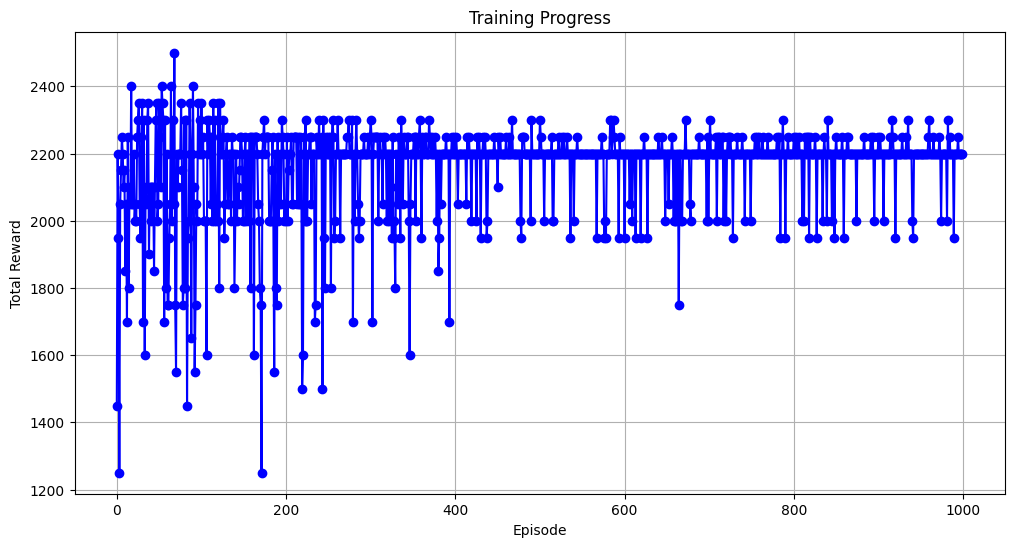

In [7]:
import matplotlib.pyplot as plt

# Analyze and plot the training results
plt.figure(figsize=(12, 6))
plt.plot(episode_rewards, marker='o', linestyle='-', color='b')
plt.title('Training Progress')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import multiprocessing

# Define a function to create and train the agent
def create_and_train_agent(lr, epsilon, discount_factor, num_episodes=1000):
    # Create the agent with the specified hyperparameters
    agent = CustomRLAgent(state_dim=state_dim, action_dim=action_dim, learning_rate=lr, epsilon=epsilon, discount_factor=discount_factor)
    
    episode_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0

        while True:
            action = agent.select_action(state)
            next_state, reward, done = env.step(action)

            episode_reward += reward

            agent.train(state, action, reward, next_state, done)

            if done:
                break

            state = next_state

        episode_rewards.append(episode_reward)

        # Update the target model
        if episode % 100 == 0:
            agent.update_target_model()

    return episode_rewards

In [ ]:
# Define the hyperparameters to search
learning_rates = [0.001, 0.01, 0.1]
epsilons = [0.1, 0.2, 0.3]
discount_factors = [0.95, 0.99, 0.995]

best_average_reward = -np.inf
best_hyperparameters = {}

# Create a list to store results from different agents
results = []

# Define the number of parallel processes
num_processes = multiprocessing.cpu_count()

# Iterate over hyperparameters
for lr in learning_rates:
    for epsilon in epsilons:
        for discount_factor in discount_factors:
            # Use multiprocessing to train agents in parallel
            with multiprocessing.Pool(processes=num_processes) as pool:
                episode_rewards_list = pool.starmap(create_and_train_agent, [(lr, epsilon, discount_factor)] * num_processes)

            # Calculate the average reward over all agents
            average_reward = np.mean([np.mean(rewards) for rewards in episode_rewards_list])

            # Print and record results
            print(f"lr={lr}, epsilon={epsilon}, discount_factor={discount_factor}: Average Reward = {average_reward}")

            # Check if this combination of hyperparameters resulted in a better average reward
            if average_reward > best_average_reward:
                best_average_reward = average_reward
                best_hyperparameters = {
                    'learning_rate': lr,
                    'epsilon': epsilon,
                    'discount_factor': discount_factor
                }

print("Best Hyperparameters:", best_hyperparameters)
print("Best Average Reward:", best_average_reward)